In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import array


%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
data_dir = '/data'
filename = '/data.csv'

data_df = pd.read_csv('data/data.csv')

In [4]:
data_df.head()
print(data_df.shape)

(116, 44)


In [95]:
print(data_df.columns.values)

['year' 'annual-min' 'jan-min' 'feb-min' 'mar-min' 'apr-min' 'may-min'
 'jun-min' 'jul-min' 'aug-min' 'sep-min' 'oct-min' 'nov-min' 'dec-min'
 'annual-max' 'jan-max' 'feb-max' 'mar-max' 'apr-max' 'may-max' 'jun-max'
 'jul-max' 'aug-max' 'sep-max' 'oct-max' 'nov-max' 'dec-max' 'annual-mean'
 'jan-mean' 'feb-mean' 'mar-mean' 'apr-mean' 'may-mean' 'jun-mean'
 'jul-mean' 'aug-mean' 'sep-mean' 'oct-mean' 'nov-mean' 'dec-mean'
 'jun-rain' 'jul-rain' 'aug-rain' 'sept-rain']


In [93]:
data_df.head()

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
0,1901,19.51,13.58,14.72,17.91,20.93,23.18,24.05,23.82,23.58,...,27.49,26.98,26.26,25.08,21.73,18.95,99.3,295.4,354.8,113.8
1,1902,19.44,13.08,14.20,18.44,21.30,23.63,23.97,23.68,23.34,...,27.29,27.05,25.95,24.37,21.33,18.78,62.3,334.2,237.6,216.0
2,1903,19.25,13.20,14.55,17.12,20.67,22.95,23.85,23.53,23.29,...,28.04,26.63,26.34,24.57,20.96,18.29,96.2,392.7,286.6,211.5
3,1904,19.22,13.04,14.07,17.70,21.42,23.02,23.64,23.35,23.03,...,26.84,26.73,25.84,24.36,21.07,18.84,180.5,259.1,200.9,165.8
4,1905,19.03,12.83,12.74,16.88,19.62,23.32,24.13,23.93,24.31,...,27.67,27.47,26.29,26.16,22.07,18.71,59.8,340.6,178.9,204.1


In [94]:
data_df.tail()

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
111,2012,19.54,12.91,14.45,17.79,21.30,23.15,24.22,24.12,23.69,...,27.98,27.31,26.65,24.85,22.26,19.91,99.3,311.9,305.5,218.2
112,2013,19.83,13.22,15.54,18.45,21.29,23.68,24.08,23.94,23.70,...,27.50,27.22,26.87,25.63,22.18,19.69,275.9,437.6,299.2,180.7
113,2014,19.77,13.79,14.72,17.73,21.07,23.16,24.68,24.37,23.58,...,28.07,27.42,26.61,25.38,22.53,19.50,64.6,358.5,256.4,201.1
114,2015,19.96,13.51,15.55,17.99,21.18,23.54,23.82,24.28,23.82,...,28.03,27.64,27.04,25.82,22.95,20.21,204.5,267.9,204.8,141.8
115,2016,21.28,14.91,17.44,20.59,23.75,25.10,25.36,24.72,24.56,...,28.18,28.17,27.72,26.81,23.90,21.89,137.3,382.9,320.9,194.6


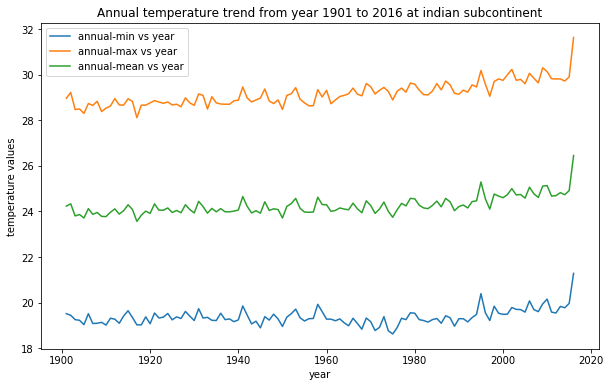

In [96]:
#visualizing the temperature data
plt.figure(figsize=(10,6))
plt.plot(data_df['year'], data_df['annual-min'], label='annual-min vs year') 
plt.plot(data_df['year'], data_df['annual-max'], label='annual-max vs year')
plt.plot(data_df['year'], data_df['annual-mean'], label='annual-mean vs year')
plt.title('Annual temperature trend from year 1901 to 2016 at indian subcontinent')
plt.legend(loc='best')
plt.xlabel('year')
plt.ylabel('temperature values')
plt.show()

It can be seen that there has been an evident rise in all format of temperatures along the year. Also, on careful visualization, one can see more sharp rise in later years than early years.

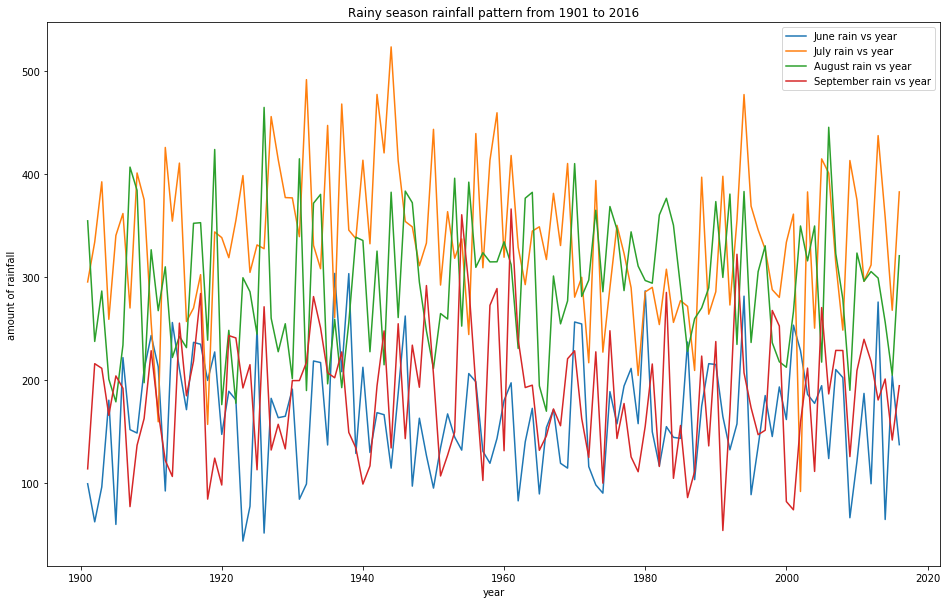

In [97]:
#Visualizing the rainfall data
plt.figure(figsize=(16,10))
plt.plot(data_df['year'], data_df['jun-rain'], label='June rain vs year')
plt.plot(data_df['year'], data_df['jul-rain'], label='July rain vs year')
plt.plot(data_df['year'], data_df['aug-rain'], label='August rain vs year')
plt.plot(data_df['year'], data_df['sept-rain'], label='September rain vs year')
plt.title('Rainy season rainfall pattern from 1901 to 2016')
plt.legend(loc='best')
plt.xlabel('year')
plt.ylabel('amount of rainfall')
plt.show()

Clearly it can be seen that month of June and September which marks beginning and end of monsoon in india get similar amount of rainfall with maximum rainfall happening in month of July followed by August.

In [5]:
train = data_df[:100]
test = data_df[100:]

In [6]:
train1 = train.copy()

In [7]:
train1 = train1.drop(['year'], axis=1)

In [8]:
headers = list(train1.columns.values)

In [91]:
print(headers)

['annual-min', 'jan-min', 'feb-min', 'mar-min', 'apr-min', 'may-min', 'jun-min', 'jul-min', 'aug-min', 'sep-min', 'oct-min', 'nov-min', 'dec-min', 'annual-max', 'jan-max', 'feb-max', 'mar-max', 'apr-max', 'may-max', 'jun-max', 'jul-max', 'aug-max', 'sep-max', 'oct-max', 'nov-max', 'dec-max', 'annual-mean', 'jan-mean', 'feb-mean', 'mar-mean', 'apr-mean', 'may-mean', 'jun-mean', 'jul-mean', 'aug-mean', 'sep-mean', 'oct-mean', 'nov-mean', 'dec-mean', 'jun-rain', 'jul-rain', 'aug-rain', 'sept-rain']


# Simple Exponential Smoothing
While working on time series problem, one needs  to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple exponential smoothing. Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations:

$$ŷ_(t+1|t) =  α*y(t) + α(1-α)*y(t-1) + α(1-α)^{2} * y(t-2) + ....$$

where 0≤ α ≤1 is the smoothing parameter.
The one-step-ahead forecast for time T+1 is a weighted average of all the observations in the series y1,…,yT. The rate at which the weights decrease is controlled by the parameter α.

In [10]:
y_hat_exp = test.copy()
for header in headers:
    fit_exp = SimpleExpSmoothing(np.asarray(train1[header])).fit(smoothing_level=0.3, optimized=False)
    y_hat_exp[header] = fit_exp.forecast(len(test))



In [101]:
y_hat_exp.head()

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
100,2001,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599
101,2002,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599
102,2003,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599
103,2004,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599
104,2005,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599


In [12]:
rmse_exp = {}
for header in headers:
    rmse_exp[header] = sqrt(mean_squared_error(test[header], y_hat_exp[header]))

rmse_exp

{'annual-min': 0.5132513590975231,
 'jan-min': 0.6665157046452513,
 'feb-min': 0.8806026708421039,
 'mar-min': 1.015602222782082,
 'apr-min': 0.8328656215104412,
 'may-min': 0.5684815367159812,
 'jun-min': 0.5039300206208394,
 'jul-min': 0.3459972223268492,
 'aug-min': 0.41679828566889154,
 'sep-min': 0.41923865374130037,
 'oct-min': 0.7289138717350783,
 'nov-min': 0.5869387599421291,
 'dec-min': 0.9010448856240822,
 'annual-max': 0.5807570993892286,
 'jan-max': 0.97691944182958,
 'feb-max': 1.43349528337312,
 'mar-max': 1.3539781306641319,
 'apr-max': 0.8877859013655024,
 'may-max': 0.6909737180277318,
 'jun-max': 0.7346333131789662,
 'jul-max': 0.48054961389241996,
 'aug-max': 0.4553696493250594,
 'sep-max': 0.3835067127283721,
 'oct-max': 0.6287592398944386,
 'nov-max': 0.6256138646394915,
 'dec-max': 0.7187415985188413,
 'annual-mean': 0.5432060461454536,
 'jan-mean': 0.748311289601709,
 'feb-mean': 1.117403224451074,
 'mar-mean': 1.3135687713563002,
 'apr-mean': 0.8484687905322217

#### smmothing_level = 0.5, 0.3, 0.1, 0.8 were used to study above model and smoothing_level value of 0.3 produced minimum rmse

# Holt’s Linear Trend method

Holt extended simple exponential smoothing to allow forecasting of data with a trend. It is nothing more than exponential smoothing applied to both level(the average value in the series) and trend. To express this in mathematical notation we now need three equations: one for level, one for the trend and one to combine the level and trend to get the expected forecast ŷ

### Forecast: $$ŷ(t+h|t) = l_t + h*b_t$$
### Level equation: $$l_t = α*y_t + (1-α)(l_(t-1) + b_(t-1)) $$
### Trend equation: $$b_t = <beta>*(l_t - l_(t-1)) + (1-<beta>)b_(t-1)  $$

As with simple exponential smoothing, the level equation here shows that it is a weighted average of observation and the within-sample one-step-ahead forecast The trend equation shows that it is a weighted average of the estimated trend at time t based on l(t)−l(t−1) and b(t−1), the previous estimate of the trend.

We will add these equations to generate Forecast equation. We can also generate a multiplicative forecast equation by multiplying trend and level instead of adding it. When the trend increases or decreases linearly, additive equation is used whereas when the trend increases of decreases exponentially, multiplicative equation is used.Practice shows that multiplicative is a more stable predictor, the additive method however is simpler to understand

In [98]:
y_hat_holt = test.copy()
#using holt algorith on each column
for header in headers:
    fit_holt = Holt(np.asarray(train1[header])).fit(smoothing_slope=0.1, smoothing_level=0.3)
    y_hat_holt[header] = fit_holt.forecast(len(test))

In [99]:
#view predicted values
y_hat_holt

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
100,2001,19.630591,13.449988,15.135921,17.852601,21.226862,23.443323,23.875639,23.903836,23.448318,...,27.620695,27.155187,26.756656,25.197854,22.518054,19.543703,166.123849,329.430032,240.547655,182.450035
101,2002,19.652125,13.476113,15.166715,17.854498,21.261269,23.477111,23.880699,23.923653,23.456172,...,27.638426,27.166602,26.777337,25.233569,22.563705,19.550941,165.824996,330.009141,234.927333,182.751298
102,2003,19.673658,13.502238,15.197509,17.856395,21.295676,23.510899,23.885759,23.943470,23.464025,...,27.656157,27.178016,26.798017,25.269284,22.609356,19.558179,165.526142,330.588250,229.307012,183.052560
103,2004,19.695191,13.528363,15.228303,17.858293,21.330083,23.544687,23.890819,23.963287,23.471879,...,27.673888,27.189430,26.818698,25.304999,22.655006,19.565418,165.227289,331.167360,223.686691,183.353822
104,2005,19.716725,13.554488,15.259097,17.860190,21.364490,23.578476,23.895879,23.983103,23.479733,...,27.691619,27.200845,26.839378,25.340714,22.700657,19.572656,164.928435,331.746469,218.066369,183.655085
105,2006,19.738258,13.580613,15.289891,17.862087,21.398897,23.612264,23.900939,24.002920,23.487586,...,27.709350,27.212259,26.860059,25.376429,22.746308,19.579894,164.629581,332.325578,212.446048,183.956347
106,2007,19.759791,13.606738,15.320684,17.863984,21.433304,23.646052,23.905999,24.022737,23.495440,...,27.727081,27.223673,26.880739,25.412144,22.791958,19.587132,164.330728,332.904687,206.825727,184.257610
107,2008,19.781324,13.632863,15.351478,17.865882,21.467711,23.679840,23.911059,24.042554,23.503293,...,27.744812,27.235088,26.901420,25.447859,22.837609,19.594371,164.031874,333.483797,201.205405,184.558872
108,2009,19.802858,13.658987,15.382272,17.867779,21.502118,23.713629,23.916119,24.062371,23.511147,...,27.762543,27.246502,26.922100,25.483574,22.883260,19.601609,163.733021,334.062906,195.585084,184.860134
109,2010,19.824391,13.685112,15.413066,17.869676,21.536525,23.747417,23.921179,24.082188,23.519001,...,27.780274,27.257916,26.942781,25.519289,22.928911,19.608847,163.434167,334.642015,189.964763,185.161397


In [100]:
rmse_holt = {}
for header in headers:
    rmse_holt[header] = sqrt(mean_squared_error(test[header], y_hat_holt[header]))

rmse_holt

{'annual-min': 0.3782754882012478,
 'jan-min': 0.6389843450020213,
 'feb-min': 0.7695030650254343,
 'mar-min': 0.9460972689905148,
 'apr-min': 0.7421981575586143,
 'may-min': 0.537422882391022,
 'jun-min': 0.4420512566277904,
 'jul-min': 0.24162702524880955,
 'aug-min': 0.33221782584140874,
 'sep-min': 0.3842107500328627,
 'oct-min': 0.6048662496055007,
 'nov-min': 0.6705496463299472,
 'dec-min': 1.0739243800004437,
 'annual-max': 0.4542389856606088,
 'jan-max': 0.8876647487651439,
 'feb-max': 1.3401265433567537,
 'mar-max': 1.1791499145704105,
 'apr-max': 1.0096082939830016,
 'may-max': 0.5865528327413381,
 'jun-max': 0.8239465510875467,
 'jul-max': 0.43088255989812174,
 'aug-max': 0.3729630288057104,
 'sep-max': 0.4063935596843522,
 'oct-max': 0.5545397060408543,
 'nov-max': 0.5931996567797807,
 'dec-max': 0.6872156819493992,
 'annual-mean': 0.4079586387481922,
 'jan-mean': 0.6552004767027082,
 'feb-mean': 0.9733467288392899,
 'mar-mean': 1.1710152520134938,
 'apr-mean': 0.8310032080

#### one can see that predictions are improving compared to simple exponential model. In holt, unlike to simple exponential model, we are getting different value for subsequent years. RMSE has improved for most of the temperature features while it has degraded for rainfall predictions. One reason for this could be that temperature displays more of a linear trend as compared to rainfall data

# Multivariate LSTM forecast model

In [16]:
#creating a separate dataset for LSTM
data_lstm = data_df.copy()

## LSTM dataset preparation

This involves normalizing the inputs

In [17]:
data_lstm.columns

Index(['year', 'annual-min', 'jan-min', 'feb-min', 'mar-min', 'apr-min',
       'may-min', 'jun-min', 'jul-min', 'aug-min', 'sep-min', 'oct-min',
       'nov-min', 'dec-min', 'annual-max', 'jan-max', 'feb-max', 'mar-max',
       'apr-max', 'may-max', 'jun-max', 'jul-max', 'aug-max', 'sep-max',
       'oct-max', 'nov-max', 'dec-max', 'annual-mean', 'jan-mean', 'feb-mean',
       'mar-mean', 'apr-mean', 'may-mean', 'jun-mean', 'jul-mean', 'aug-mean',
       'sep-mean', 'oct-mean', 'nov-mean', 'dec-mean', 'jun-rain', 'jul-rain',
       'aug-rain', 'sept-rain'],
      dtype='object')

In [18]:
#dropping year column from dataset
data_lstm = data_lstm.drop(['year'], axis=1)

In [19]:
all_data = data_lstm[data_lstm.columns.values].values.astype('float32')

In [20]:
print(all_data[0])
print(all_data[1])

[ 19.51  13.58  14.72  17.91  20.93  23.18  24.05  23.82  23.58  22.09
  20.2   16.16  13.41  28.96  22.4   24.14  29.07  31.91  33.41  33.18
  31.21  30.39  30.47  29.97  27.31  24.49  24.23  17.99  19.43  23.49
  26.41  28.28  28.6   27.49  26.98  26.26  25.08  21.73  18.95  99.3
 295.4  354.8  113.8 ]
[ 19.44  13.08  14.2   18.44  21.3   23.63  23.97  23.68  23.34  22.11
  19.63  16.35  13.53  29.22  24.93  26.58  29.77  31.78  33.73  32.91
  30.92  30.73  29.8   29.12  26.31  24.04  24.33  19.    20.39  24.1
  26.54  28.68  28.44  27.29  27.05  25.95  24.37  21.33  18.78  62.3
 334.2  237.6  216.  ]


In [21]:
print(all_data.shape)

(116, 43)


In [22]:
#train_test_split
test_data_size = 10
train_data_lstm = all_data[:-test_data_size]
test_data_lstm = all_data[-test_data_size:]

In [23]:
print(train_data_lstm.shape)
print(test_data_lstm.shape)

(106, 43)
(10, 43)


In [24]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(-1, 1))
train_data_lstm_normalized = scale.fit_transform(train_data_lstm)

In [25]:
print(train_data_lstm_normalized.shape)

(106, 43)


In [26]:
print(train_data_lstm_normalized[:2])
print(train_data_lstm_normalized[-2:])

[[ 0.00564957  0.27196598  0.         -0.0851078   0.02745056 -0.35092354
  -0.06493568  0.44444466  0.15607071 -0.22891617 -0.01754284 -0.14195538
  -0.10163879 -0.1981144  -0.7814207  -0.5969238  -0.15398216  0.01063919
  -0.2429676   0.23077011 -0.03333473  0.0093441   0.08108139  0.24698639
   0.01898575 -0.07836914 -0.22543526 -0.4538746  -0.372849   -0.22449017
   0.11347389 -0.31233597 -0.00392151  0.01507568  0.09219742 -0.05952263
   0.18181801 -0.1162796  -0.27340698 -0.57170314 -0.05740738  0.25338745
  -0.6165173 ]
 [-0.07344627 -0.14644432 -0.26262617  0.29078007  0.31764603 -0.11345768
  -0.13419914  0.27160645 -0.12138557 -0.20481873 -0.41754436 -0.02208138
  -0.02295017  0.04717064  0.6010933   0.15384579  0.09380531 -0.05850983
  -0.07928467  0.07100677 -0.2266674   0.32710075 -0.43629456 -0.26506042
  -0.61392593 -0.36050034 -0.10982704  0.29151344 -0.00573635  0.05215359
   0.20567513 -0.10236263 -0.1294117  -0.18592834  0.19148636 -0.4285698
  -0.35606003 -0.4263572

Here data normalization is only applied on the training data and not on the test data. If normalization is applied on the test data, there is a chance that some information will be leaked from training set into the test set.

Since, Pytorch will be used to implement LSTMs, train data will be converted to tensors

In [27]:
#converting training data into tensor
train_data_lstm_normalized = torch.FloatTensor(train_data_lstm_normalized)
print(train_data_lstm_normalized.shape)

torch.Size([106, 43])


### Since we have yearly dataset, we will be using sequence length = 1

In [28]:
print(train_data_lstm_normalized[0:3])

tensor([[ 0.0056,  0.2720,  0.0000, -0.0851,  0.0275, -0.3509, -0.0649,  0.4444,
          0.1561, -0.2289, -0.0175, -0.1420, -0.1016, -0.1981, -0.7814, -0.5969,
         -0.1540,  0.0106, -0.2430,  0.2308, -0.0333,  0.0093,  0.0811,  0.2470,
          0.0190, -0.0784, -0.2254, -0.4539, -0.3728, -0.2245,  0.1135, -0.3123,
         -0.0039,  0.0151,  0.0922, -0.0595,  0.1818, -0.1163, -0.2734, -0.5717,
         -0.0574,  0.2534, -0.6165],
        [-0.0734, -0.1464, -0.2626,  0.2908,  0.3176, -0.1135, -0.1342,  0.2716,
         -0.1214, -0.2048, -0.4175, -0.0221, -0.0230,  0.0472,  0.6011,  0.1538,
          0.0938, -0.0585, -0.0793,  0.0710, -0.2267,  0.3271, -0.4363, -0.2651,
         -0.6139, -0.3605, -0.1098,  0.2915, -0.0057,  0.0522,  0.2057, -0.1024,
         -0.1294, -0.1859,  0.1915, -0.4286, -0.3561, -0.4264, -0.4007, -0.8562,
          0.1222, -0.5407,  0.0378],
        [-0.2881, -0.0460, -0.0859, -0.6454, -0.1765, -0.4723, -0.2381,  0.0864,
         -0.1792,  0.6747, -0.0737,

In [29]:
seq_len = 24
def create_sequence(input_data, seq_len):
    sequence = []
    l = len(input_data)
    for i in range(l-seq_len):
        train_seq = input_data[i:i+seq_len]
        try:
            train_label = input_data[i+seq_len: i+seq_len+1]
        except IndexError:
            train_label = input_data[0]
        sequence.append((train_seq, train_label))
    return sequence

In [30]:
train_data_lstm_seq = create_sequence(train_data_lstm_normalized, seq_len)
#print(train_data_lstm_seq[0].size(0))
#print(train_data_lstm_seq[1])

In [31]:
#Defininig LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, n_layers):
        super().__init__()
        """
        Initialize pytorch model
        parameters:
        input_size - number of input features in dataset
        hidden_layer_size - hidden layer dimension
        output_size - number of output. here, it is equal to number of input features
        n_layers - number of layers in LSTM module
        """
        
        self.hidden_layer_size = hidden_layer_size
        self.n_layers = n_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, n_layers)
        self.fc = nn.Linear(hidden_layer_size, output_size)
        
        
        
    def forward(self, nn_input, hidden):
        """
        Forward propagation of neural networks
        parameters:
        nn_input - input to the neural network
        hidden - the hidden state
        return - output of neural network and last hidden state
        """
        
        #nn_input = nn_input.long()
        batch_size = nn_input.size(0)
        
        lstm_out, hidden = self.lstm(nn_input.view(len(nn_input),1,-1), hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_layer_size)
        
        output = self.fc(lstm_out)
        
        output = output.view(batch_size, -1, self.output_size)
        #getting the last output of LSTM
        output = output[-1]
        
        return output, hidden
    
    def init_hidden(self):
        """
        Initializing the hidden layer weights
        return - hidden state of dimension (n_layers, hidden_layer_size)
        """
        
        weight = next(self.parameters()).data
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        hidden = (weight.new(self.n_layers, 1, self.hidden_layer_size).zero_().to(device),
                 weight.new(self.n_layers, 1, self.hidden_layer_size).zero_().to(device))
        
        return hidden

In [32]:
#defining parameters
input_size = train_data_lstm_normalized.shape[1]
hidden_layer_size = 100
output_size = input_size
n_layers = 2

In [33]:
device =  'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
model = LSTM(input_size, hidden_layer_size, output_size, n_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [35]:
print(model)

LSTM(
  (lstm): LSTM(43, 100, num_layers=2)
  (fc): Linear(in_features=100, out_features=43, bias=True)
)


In [36]:
#training our model

n_epochs = 300

for i in range(1, n_epochs+1):
    for seq, target in train_data_lstm_seq:
        #moving our data to device
        seq, target = seq.to(device), target.to(device)
        
        optimizer.zero_grad()
        #hidden = model.init_hidden()
        hidden = model.init_hidden()

        
        prediction, hidden = model(seq, hidden)
        
        loss = criterion(prediction, target)
        loss.backward()
        #clipping the values to prevent exploding gradient
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()
    #printing loss every 10 epoch    
    if i%20==0:
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')

epoch:  20 loss: 0.14653754
epoch:  40 loss: 0.14937699
epoch:  60 loss: 0.15000241
epoch:  80 loss: 0.13896376
epoch: 100 loss: 0.12468010
epoch: 120 loss: 0.11031290
epoch: 140 loss: 0.09730291
epoch: 160 loss: 0.09258043
epoch: 180 loss: 0.08140647
epoch: 200 loss: 0.05615724
epoch: 220 loss: 0.04572145
epoch: 240 loss: 0.03613112
epoch: 260 loss: 0.02738274
epoch: 280 loss: 0.02387728
epoch: 300 loss: 0.03016614


# Loss data with parameters
###### loss = 0.16984613; parameters: hidden_dim=100, n_layers=2, lr=0.0001, sequence_length=1, n_epochs=100
###### loss = 0.17003609; parameters: hidden_dim=100, n_layers=1, lr=0.0001, sequence_length=1, n_epochs=100
###### loss = 0.17011546; parameters: hidden_dim=150, n_layers=2, lr=0.0001, sequence_length=1,n_epochs=100
###### loss = 0.16984379; parameters: hidden_dim=150, n_layers=1, lr=0.0001, sequence_length=1,n_epochs=100
###### loss = 0.16991393; parameters: hidden_dim=250, n_layers=2, lr=0.0001, sequence_length=1,n_epochs=100
###### loss = 0.16984379; parameters: hidden_dim=250, n_layers=1, lr=0.0001, sequence_length=1,n_epochs=100
###### loss = 0.16984379; parameters: hidden_dim=250, n_layers=1, lr=0.0001, sequence_length=1,n_epochs=200
###### loss = 0.16986375; parameters: hidden_dim=50, n_layers=2, lr=0.0001, sequence_length=1,n_epochs=100
###### loss = 0.17167109; parameters: hidden_dim=50, n_layers=1, lr=0.0001, sequence_length=1,n_epochs=100
###### loss = 0.14154065; parameters: hidden_dim=100, n_layers=2, lr=0.0001, sequence_length=3,n_epochs=100
###### loss = 0.03827548; parameters: hidden_dim=100, n_layers=2, lr=0.0001, sequence_length=12,n_epochs=300
###### loss = 0.03016614; parameters: hidden_dim=100, n_layers=2, lr=0.0001, sequence_length=24,n_epochs=300(final parameters)

In [66]:
n_test = test_data_lstm.shape[0]
test_initial_seq = train_data_lstm_normalized[-seq_len:].tolist()
print((torch.FloatTensor(test_initial_seq[-seq_len:])).shape)
print(type(test_initial_seq))

torch.Size([24, 43])
<class 'list'>


In [67]:
model.eval()
for i in range(n_test):
    seq = torch.FloatTensor(test_initial_seq[-seq_len:])
    with torch.no_grad():
        hidden = model.init_hidden()
        pred, _ = model(seq, hidden)
        pred = pred.squeeze().cpu().tolist()
        test_initial_seq.append(pred)

In [68]:
#length of test_initial_seq should be greater than 10
print(len(test_initial_seq))

34


In [71]:
#extract last 10 values of test results
predicted_values = test_initial_seq[-n_test:]
print(len(predicted_values))

10


In [74]:
actual_test_predictions = scale.inverse_transform(predicted_values)

In [103]:
print(actual_test_predictions[0:2])

[[ 20.06979198  14.52885816  16.7795732   18.45036343  20.99805749
   23.77768236  23.81158383  24.13498087  23.6132477   22.4125571
   20.27684979  16.92924788  14.31642946  30.00139605  25.36398706
   28.54035313  29.73786721  32.55520279  33.83709416  32.8067165
   31.56604517  30.83130251  30.68908977  30.34749501  27.57730665
   25.28659441  24.99018159  19.90677655  23.11552704  23.87492972
   26.67469927  28.82467079  28.19238962  27.73275491  27.2182381
   26.51852252  25.40510668  22.2912687   19.89277654 148.76704976
  409.50337868 378.63520005 209.39951201]
 [ 20.03324378  14.37253402  16.6278257   18.44253776  20.95675068
   23.71867409  23.70383737  24.12147634  23.6074143   22.43224588
   20.23080487  16.94115397  14.27781737  30.01445017  25.11523779
   28.63271958  29.90335589  32.54777544  33.73989144  32.63152159
   31.61666265  30.80758821  30.72053042  30.3181025   27.45221668
   25.13648686  24.96084191  19.73539308  23.04785745  23.8523755
   26.66082885  28.69916

In [76]:
test_lstm = test[-n_test:]

In [77]:
y_hat_lstm = test_lstm.copy()

In [78]:
for i in range(len(headers)):
    y_hat_lstm[headers[i]] = actual_test_predictions[:, i]

In [130]:
y_hat_lstm.head()

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
106,2007,20.069792,14.528858,16.779573,18.450363,20.998057,23.777682,23.811584,24.134981,23.613248,...,27.732755,27.218238,26.518523,25.405107,22.291269,19.892777,148.767050,409.503379,378.635200,209.399512
107,2008,20.033244,14.372534,16.627826,18.442538,20.956751,23.718674,23.703837,24.121476,23.607414,...,27.746987,27.227437,26.576965,25.364215,22.272593,19.880729,158.000355,393.225207,361.431707,192.791748
108,2009,20.017523,14.192190,16.463240,18.374727,20.982690,23.651766,23.676260,24.088888,23.594540,...,27.757179,27.232305,26.589230,25.318347,22.271761,19.828104,160.979979,369.632715,343.616167,194.310845
109,2010,19.995715,14.023429,16.282796,18.322766,21.038330,23.561846,23.636722,24.013812,23.559266,...,27.718846,27.211404,26.562330,25.277462,22.281788,19.749046,167.579252,347.424189,325.823927,198.239778
110,2011,19.984668,13.922332,16.148652,18.247531,21.096845,23.596612,23.596240,23.952731,23.532750,...,27.688691,27.194708,26.525331,25.291987,22.360414,19.721651,178.556065,334.978049,313.300484,198.244589


In [104]:
rmse_lstm = {}
for header in headers:
    rmse_lstm[header] = sqrt(mean_squared_error(test_lstm[header], y_hat_lstm[header]))

rmse_lstm

{'annual-min': 0.4914297464716202,
 'jan-min': 0.8923853821199306,
 'feb-min': 1.3039211737236787,
 'mar-min': 0.896117960036379,
 'apr-min': 1.0370411286949084,
 'may-min': 0.5937288697887277,
 'jun-min': 0.7227594779693627,
 'jul-min': 0.33253452112003457,
 'aug-min': 0.3858588190592551,
 'sep-min': 0.4246842380326448,
 'oct-min': 0.7367605141260767,
 'nov-min': 0.5622321400554741,
 'dec-min': 0.7831636479292476,
 'annual-max': 0.5815378157573945,
 'jan-max': 0.9415617184631693,
 'feb-max': 1.9135257745977032,
 'mar-max': 1.29893589643481,
 'apr-max': 1.1218977898963294,
 'may-max': 0.714828561249209,
 'jun-max': 0.8887489716619672,
 'jul-max': 0.2975629209756805,
 'aug-max': 0.5474151466929394,
 'sep-max': 0.5252646886797476,
 'oct-max': 0.7015421093062395,
 'nov-max': 1.007166023625734,
 'dec-max': 1.025935208925279,
 'annual-mean': 0.5271656553098051,
 'jan-mean': 0.8505625760473516,
 'feb-mean': 1.7986768820692742,
 'mar-mean': 1.2691444678621495,
 'apr-mean': 1.1178954044556408,

### Plotting
since temperature and rainfall RMSEs are vastly different in scale, they will be plotted in two different graphs for better visualization

In [126]:
data_rmseT = {"x":[], "y":[], "z": [], "axis_label":[]}
data_rmseR = {"x":[], "y":[], "z": [], "axis_label":[]}
for key, value in rmse_exp.items():
    if (key != 'jun-rain' and key != 'jul-rain' and key != 'aug-rain' and key != 'sept-rain'):
        data_rmseT["x"].append(value)
        data_rmseT["axis_label"].append(key)
    else:
        data_rmseR["x"].append(value)
        data_rmseR["axis_label"].append(key)

for key, value in rmse_lstm.items():
    if (key != 'jun-rain' and key != 'jul-rain' and key != 'aug-rain' and key != 'sept-rain'):
        data_rmseT["y"].append(value)
    else:
        data_rmseR["y"].append(value)
    
for key, value in rmse_holt.items():
    if (key != 'jun-rain' and key != 'jul-rain' and key != 'aug-rain' and key != 'sept-rain'):
        data_rmseT["z"].append(value)
    else:
        data_rmseR["z"].append(value)

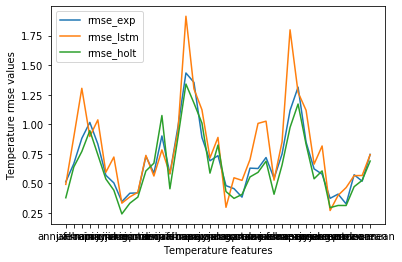

In [127]:
plt.plot(data_rmseT["axis_label"], data_rmseT["x"], label="rmse_exp")
plt.plot(data_rmseT["axis_label"], data_rmseT["y"],label="rmse_lstm")
plt.plot(data_rmseT["axis_label"], data_rmseT["z"], label="rmse_holt")
plt.legend(loc='best')
plt.xlabel('Temperature features')
plt.ylabel('Temperature rmse values')
plt.show()

In [128]:
data_rmseR

{'x': [60.917211442572395,
  85.53031188283303,
  76.23888311275189,
  51.541648493899096],
 'y': [71.02655610708626,
  74.0402090020612,
  70.98978716425856,
  34.72393841169928],
 'z': [60.71868894321681,
  84.35476455298,
  114.66232484466823,
  50.14400719963588],
 'axis_label': ['jun-rain', 'jul-rain', 'aug-rain', 'sept-rain']}

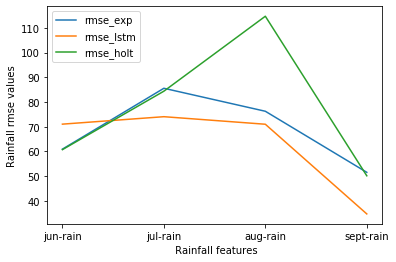

In [129]:
plt.plot(data_rmseR["axis_label"], data_rmseR["x"], label="rmse_exp")
plt.plot(data_rmseR["axis_label"], data_rmseR["y"],label="rmse_lstm")
plt.plot(data_rmseR["axis_label"], data_rmseR["z"], label="rmse_holt")
plt.legend(loc='best')
plt.xlabel(' Rainfall features')
plt.ylabel('Rainfall rmse values')
plt.show()

It can be seen that temperature rmse are nearly similar for all the three methods with two spikes in case of lstm network. The incease in rmse value for LSTM network at these two points can be attributed to overfitting. There were two variables in the training dataset with different kind of time series relationship. Temperature had more degree of linearity as opposed to rainfall which was evident from rmse values of simple exponential method and holt linear trend method. Hence, to accomodate for high non-linearity of rainfall features, complex LSTM networks were used which lead to slight overfitting for temperature features. 
From rainfall rmse plot, it can be clearyly seen that LSMT network has outperformed the other two methods by a huge margin. Holt linear trend method performs worse than even benchmark model. This signifies that there is high degree of non-linearity involved in rainfall features data